## Task Understanding

Ta sẽ xây dựng mô hình máy học sử dụng mạng CNN để chẩn đoán xem bệnh sốt rét ở người dựa trên thông tin tế bào thu được từ kính hiển vi.

Nhiệm vụ: Cần phân loại chính xác liệu ảnh đầu vào có chứa ký sinh trùng sốt rét hay không?

## Data

Dữ liệu sẽ được lấy trong bộ dữ liệu của [Tensorflow Malaria Dataset](https://www.tensorflow.org/datasets/catalog/malaria)

Ta tiến hành tải dữ liệu

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, InputLayer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

In [93]:
dataset, data_info = tfds.load('malaria', shuffle_files=True, as_supervised=True, with_info=True)

In [94]:
len(dataset['train'])

27558

### Phân chia dữ liệu

In [95]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    train_dataset = dataset.take(int(len(dataset)*TRAIN_RATIO))
    val_dataset = dataset.skip(int(len(dataset)*TRAIN_RATIO))
    val_dataset = val_dataset.take(int(len(dataset)*VAL_RATIO))
    test_dataset = dataset.skip(int(len(dataset)*VAL_RATIO) + int(len(dataset)*TRAIN_RATIO))
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = splits(dataset['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

### Trực quan hóa dữ liệu

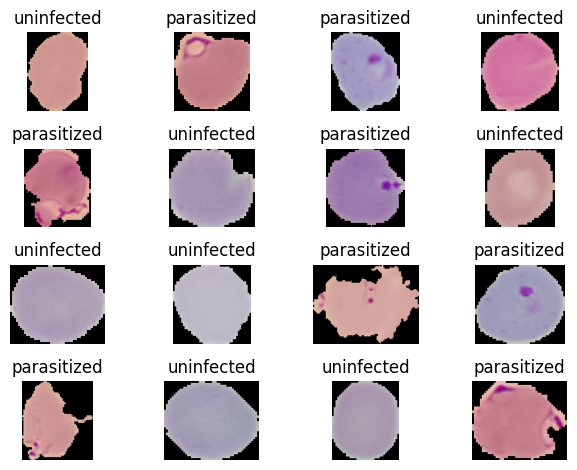

In [96]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(data_info.features['label'].int2str(label.numpy()))
    plt.axis('off')
plt.tight_layout()
plt.show()

## Data Processing

Đầu tiên ta cần đưa mọi hình ảnh về cỡ 224x224, sau đó scale ảnh bằng Min Max Scaler

Cụ thể mỗi pixel chỉ có giá trị lớn nhất là 255 và nhỏ nhất là 0 nên theo công thức

$$
x_{scaled} = \frac{x - x_{max}}{x_{max} - x_{min}}
$$

Thì mỗi pixel ta chỉ cần chia cho 255

In [97]:
IM_SIZE = 224
def resizing_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [98]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [99]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [100]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
# đây chính là mạng CNN LeNet-5
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),
    # flatten layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.save("baseline_model.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_12 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_13 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

Việc thêm lớp `BatchNormalization` vào sau mỗi đầu ra của một layer trong mô hình là để giúp cải thiện hiệu suất và tốc độ huấn luyện của model.

Lợi ích:

- Giảm sự phụ thuộc vào giá trị khởi tạo
- Tăng tốc độ huấn luyện
- Giảm hiện tượng vanishing/exploding gradient
- Tăng độ ổn định và độ chính xác

## Loss Function

Ta sử dụng hàm BinaryCrossEntropy để làm loss function

$$
cost = (-y\log(p) + (1-y)\log(1-p))
$$

Với $p$ là giá trị dự đoán và y là giá trị thực sự

Vậy

$$
Loss = \sum_{i=1}^{M} cost_i
$$

In [102]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

## Training Model

In [ ]:
history = model.fit(train_dataset, epochs=20, verbose=1, validation_data=val_dataset)

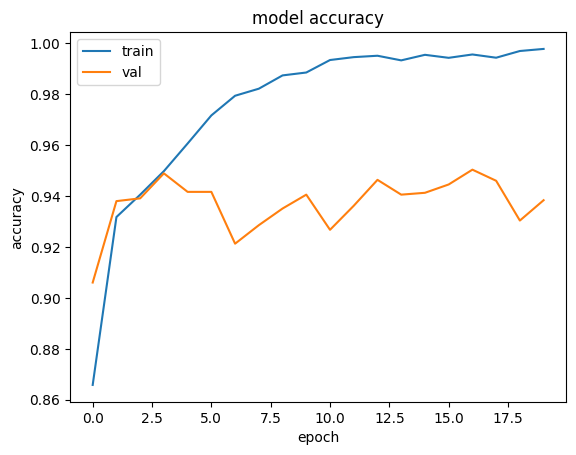

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Evaluation and Testing

In [ ]:
model.evaluate(test_dataset)

87/87 [==============================] - 4s 21ms/step - loss: 0.3484 - accuracy: 0.9380


[0.3483881950378418, 0.937976062297821]

In [ ]:
model.save('malaria_model.h5')

Ở phần xây dựng model theo cách tuần tự, ta đã xây dựng được mô hình với các lớp nối liền sau nhau. Sẽ ra sao nếu đầu vào là 2 ảnh và có 2 đầu ra?

Ví dụ đầu ra thứ 1 là dự đoán xem liệu có virut kí sinh không, đầu ra thứ 2 là vị trí chính xác mà virut nằm ở đâu trên bức ảnh.

Với Sequential API chúng ta không thể làm được điều này. Vì vậy đó là lí do Functional API quan trọng.

Tiếp theo ta xây dựng Mô Hình ResNet, một mô hình phổ biến trong DeepLearning.


Ví dụ ta có 3 lớp layers, đầu ra của lớp thứ nhất và lớp thứ 2 sẽ là đầu vào của lớp thứ 3, điều này Sequential API không thể làm được.

## Xây dựng một mô hình theo Functional API

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2, padding = 'valid')(x)

x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2, padding = 'valid')(x)


feature_extractor_model = Model(inputs=func_input, outputs=output, name = "Features_Extractor")
feature_extractor_model.summary()


Model: "Features_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 1

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_model(func_input)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(inputs=func_input, outputs=func_output, name = "Lenet_Model")
lenet_model_func.summary()


Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Features_Extractor (Functio  (None, 54, 54, 16)       1136      
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                

In [ ]:
lenet_model_func.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

Vậy ta đã tạo lại được Lenet Model bằng Functional API

## Model Subclassing

In [ ]:
class FeatureExtractor(Layer): # đây là Layer
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size, ):
    # khởi tạo các lớp
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides = 2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides = 2*strides)

  def call(self, x, training=None):
    # nối các lớp lại với nhau
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)

In [ ]:
class LenetModel(Model): # đây là Model
  def __init__(self):
    # khởi tạo các lớp
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training=None):
    # nối các lớp lại với nhau
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)

    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_12 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_13 (Bat  multiple                 

In [ ]:
lenet_sub_classed.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
history = lenet_sub_classed.fit(train_dataset, epochs = 5, verbose= 1)

Epoch 1/20
689/689 [==============================] - 33s 43ms/step - loss: 0.3623 - accuracy: 0.8438
Epoch 2/20
689/689 [==============================] - 31s 45ms/step - loss: 0.2573 - accuracy: 0.9012
Epoch 3/20
689/689 [==============================] - 35s 51ms/step - loss: 0.1915 - accuracy: 0.9293
Epoch 4/20
689/689 [==============================] - 30s 43ms/step - loss: 0.1645 - accuracy: 0.9397
Epoch 5/20
689/689 [==============================] - 30s 44ms/step - loss: 0.1294 - accuracy: 0.9530
Epoch 6/20
689/689 [==============================] - 34s 50ms/step - loss: 0.1417 - accuracy: 0.9479
Epoch 7/20
689/689 [==============================] - 32s 47ms/step - loss: 0.0975 - accuracy: 0.9632
Epoch 8/20
689/689 [==============================] - 42s 61ms/step - loss: 0.0744 - accuracy: 0.9720
Epoch 9/20
689/689 [==============================] - 34s 50ms/step - loss: 0.0559 - accuracy: 0.9804
Epoch 10/20
689/689 [==============================] - 29s 43ms/step - loss: 0.038

## Custom Layer

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.ouput_units = output_units
    self.activation = activation

  def build(self, input_feature_shape):
    # phương thức add_weight có là do kế thừa thừa Layer
    self.w = self.add_weight(shape=(input_feature_shape[-1], self.ouput_units), trainable=True, initializer="random_normal")
    self.b = self.add_weight(shape=(self.ouput_units,), trainable=True, initializer="random_normal")

  def call(self, input_feature, training=None):
    if self.activation == "relu":
      return tf.nn.relu(tf.matmul(input_feature, self.w) + self.b)
    elif self.activation == "sigmoid":
      return tf.nn.sigmoid(tf.matmul(input_feature, self.w) + self.b)
    else:
      return tf.matmul(input_feature, self.w) + self.b


Thử lại với API tuần tự

In [ ]:
lenet_custom = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = 'valid'),
    # flatten layer
    tf.keras.layers.Flatten(),
    NeuralearnDense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    NeuralearnDense(10, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    NeuralearnDense(1, activation='sigmoid')
])

lenet_custom.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_14 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_15 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

In [ ]:
lenet_custom.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

history = lenet_custom.fit(train_dataset, epochs = 5, verbose= 1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 205s 292ms/step - accuracy: 0.7586 - loss: 0.5025
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 184s 267ms/step - accuracy: 0.9159 - loss: 0.2308
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 206s 298ms/step - accuracy: 0.9259 - loss: 0.2006
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 213s 308ms/step - accuracy: 0.9330 - loss: 0.1763
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 213s 309ms/step - accuracy: 0.9359 - loss: 0.1706
